Intent Detection with DistillBert


In [1]:
!nvidia-smi

Mon May 16 12:32:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 34.8 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
     |████████████████████████████████| 84 kB 1.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [76]:
# Importing the libraries needed
import os
import math
import datetime

from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import transformers
import transformers as tf
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import torchvision.models as models
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)



In [56]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


Loading the train and test dataset from Git

In [57]:
import pandas as pd
url = 'https://github.com/hellohaptik/HINT3/blob/master/dataset/v1/train/sofmattress_train.csv?raw=true'
train = pd.read_csv(url)

print(train.head(5))

                                         sentence label
0                    You guys provide EMI option?   EMI
1  Do you offer Zero Percent EMI payment options?   EMI
2                                         0% EMI.   EMI
3                                             EMI   EMI
4                           I want in installment   EMI


In [58]:
import pandas as pd
url = 'https://github.com/hellohaptik/HINT3/blob/master/dataset/v1/test/sofmattress_test.csv?raw=true'
test = pd.read_csv(url)

print(test.head(5))

                                   sentence              label
0                   There are only 2 models  NO_NODES_DETECTED
1                                    Single  NO_NODES_DETECTED
2  What's difference between ergo and ortho         COMPARISON
3                              Return order    RETURN_EXCHANGE
4               Hai not recieved my product  DELAY_IN_DELIVERY


In [59]:
train.columns ,train.shape,test.shape

(Index(['sentence', 'label'], dtype='object'), (328, 2), (397, 2))

In [60]:
train.columns,test.columns

(Index(['sentence', 'label'], dtype='object'),
 Index(['sentence', 'label'], dtype='object'))

Checking the Intent frequency in the training data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


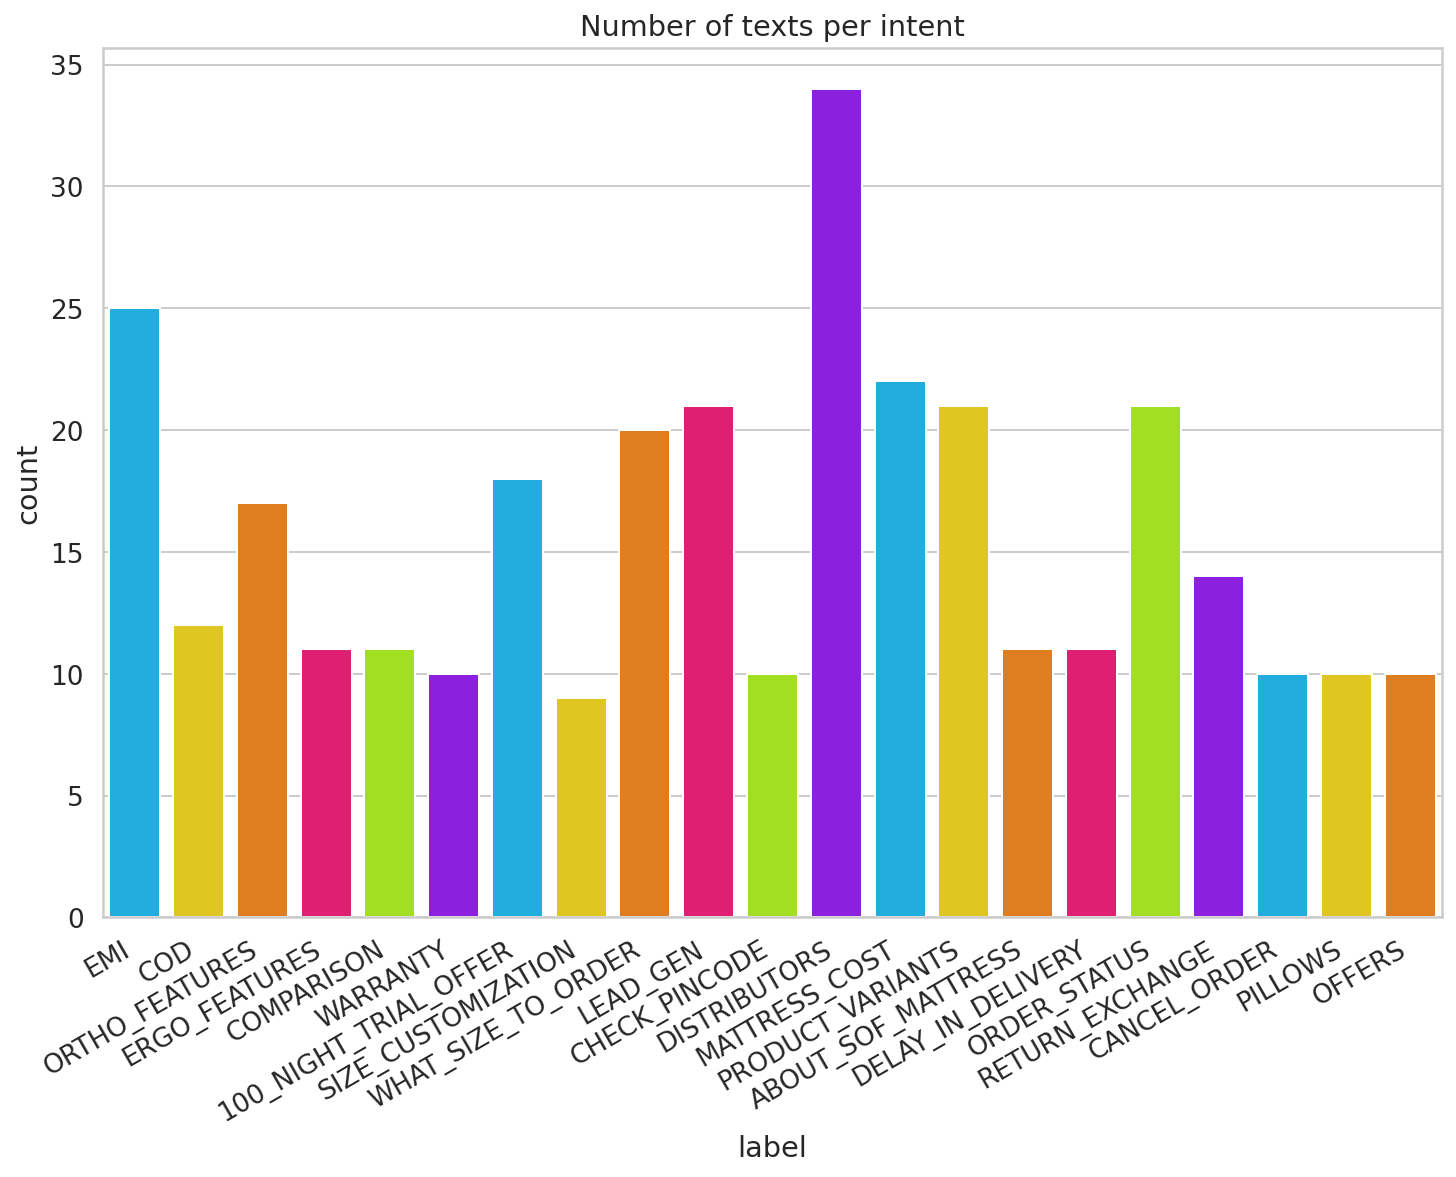

In [61]:
chart = sns.countplot(train.label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


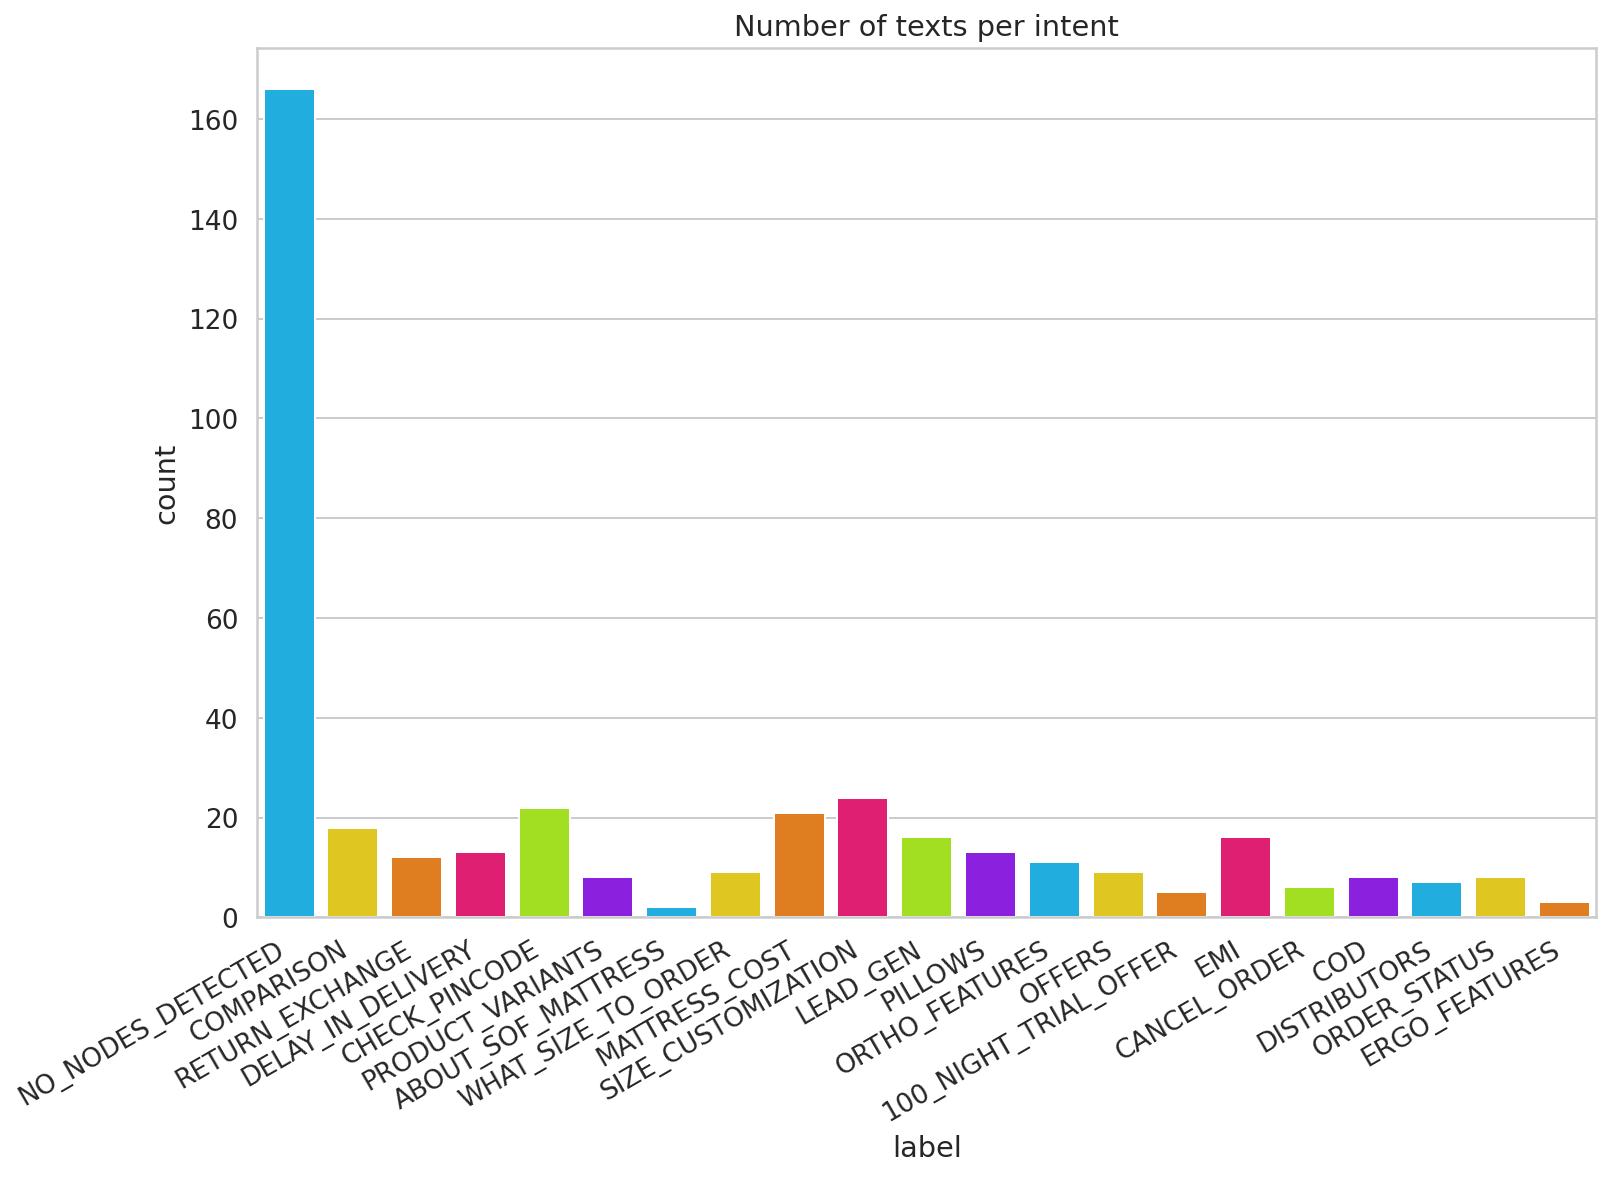

In [62]:
chart = sns.countplot(test.label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [63]:
train['label'].value_counts()

DISTRIBUTORS             34
EMI                      25
MATTRESS_COST            22
LEAD_GEN                 21
PRODUCT_VARIANTS         21
ORDER_STATUS             21
WHAT_SIZE_TO_ORDER       20
100_NIGHT_TRIAL_OFFER    18
ORTHO_FEATURES           17
RETURN_EXCHANGE          14
COD                      12
COMPARISON               11
ERGO_FEATURES            11
ABOUT_SOF_MATTRESS       11
DELAY_IN_DELIVERY        11
CANCEL_ORDER             10
PILLOWS                  10
CHECK_PINCODE            10
WARRANTY                 10
OFFERS                   10
SIZE_CUSTOMIZATION        9
Name: label, dtype: int64

In [64]:
test['label'].value_counts()

NO_NODES_DETECTED        166
SIZE_CUSTOMIZATION        24
CHECK_PINCODE             22
MATTRESS_COST             21
COMPARISON                18
EMI                       16
LEAD_GEN                  16
DELAY_IN_DELIVERY         13
PILLOWS                   13
RETURN_EXCHANGE           12
ORTHO_FEATURES            11
WHAT_SIZE_TO_ORDER         9
OFFERS                     9
PRODUCT_VARIANTS           8
COD                        8
ORDER_STATUS               8
DISTRIBUTORS               7
CANCEL_ORDER               6
100_NIGHT_TRIAL_OFFER      5
ERGO_FEATURES              3
ABOUT_SOF_MATTRESS         2
Name: label, dtype: int64

In [65]:
train['label'].unique()

array(['EMI', 'COD', 'ORTHO_FEATURES', 'ERGO_FEATURES', 'COMPARISON',
       'WARRANTY', '100_NIGHT_TRIAL_OFFER', 'SIZE_CUSTOMIZATION',
       'WHAT_SIZE_TO_ORDER', 'LEAD_GEN', 'CHECK_PINCODE', 'DISTRIBUTORS',
       'MATTRESS_COST', 'PRODUCT_VARIANTS', 'ABOUT_SOF_MATTRESS',
       'DELAY_IN_DELIVERY', 'ORDER_STATUS', 'RETURN_EXCHANGE',
       'CANCEL_ORDER', 'PILLOWS', 'OFFERS'], dtype=object)

In [14]:
len(train['label'].unique())

21

In [15]:
len(test['label'].unique())

21

In [16]:
test['label'].unique()

array(['NO_NODES_DETECTED', 'COMPARISON', 'RETURN_EXCHANGE',
       'DELAY_IN_DELIVERY', 'CHECK_PINCODE', 'PRODUCT_VARIANTS',
       'ABOUT_SOF_MATTRESS', 'WHAT_SIZE_TO_ORDER', 'MATTRESS_COST',
       'SIZE_CUSTOMIZATION', 'LEAD_GEN', 'PILLOWS', 'ORTHO_FEATURES',
       'OFFERS', '100_NIGHT_TRIAL_OFFER', 'EMI', 'CANCEL_ORDER', 'COD',
       'DISTRIBUTORS', 'ORDER_STATUS', 'ERGO_FEATURES'], dtype=object)

Create a new column and encode the category labels

In [66]:
test['encoded_cat'] = test['label'].astype('category').cat.codes


In [67]:
train['encoded_cat'] = train['label'].astype('category').cat.codes



In [68]:
train.tail(15)

,sentence,label,encoded_cat
313,Need pair of Pillows,PILLOWS,15
314,Can I buy pillows from here,PILLOWS,15
315,Do you have cushions,PILLOWS,15
316,Can I also have pillows,PILLOWS,15
317,Is pillows available,PILLOWS,15
318,Offers,OFFERS,12
319,What are the available offers,OFFERS,12
320,Give me some discount,OFFERS,12
321,Any discounts,OFFERS,12
322,Discount,OFFERS,12


In [69]:
test.tail(15)

,sentence,label,encoded_cat
382,Which to choose single or king or queen,NO_NODES_DETECTED,12
383,EMI option available ?,EMI,8
384,Which is more better to use,NO_NODES_DETECTED,12
385,I want a emi details,EMI,8
386,How many days we can get the mattress,DELAY_IN_DELIVERY,6
387,Can we return,RETURN_EXCHANGE,18
388,If we order through emi can we return it after...,RETURN_EXCHANGE,18
389,Is cash on delivery available when sleep4immun...,NO_NODES_DETECTED,12
390,When will I receive the mattress if i order today,NO_NODES_DETECTED,12
391,"Also, my bed size queen",WHAT_SIZE_TO_ORDER,20


Preparing the Dataset and Dataloader

In [21]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 3e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [22]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.sentence[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.encoded_cat[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [23]:
# Creating the dataset and dataloader for the neural network
train_size =1
random_state=200
train_dataset=train.sample(frac=train_size)
test_dataset=test.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

TRAIN Dataset: (328, 3)
TEST Dataset: (397, 3)


In [24]:
# test_dataset

In [25]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

Creating the Neural Network for Fine Tuning

In [26]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 21)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [27]:
model = DistillBERTClass()
model.to(device)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [28]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

In [29]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [30]:
# Defining the training function on  the training dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%50==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 50 steps: {loss_step}")
            print(f"Training Accuracy per 50 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [31]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Loss per 50 steps: 3.0488476753234863
Training Accuracy per 50 steps: 0.0
Training Loss per 50 steps: 3.0335985024770102
Training Accuracy per 50 steps: 8.823529411764707
The Total Accuracy for Epoch 0: 10.975609756097562
Training Loss Epoch: 2.99452642115151
Training Accuracy Epoch: 10.975609756097562
Training Loss per 50 steps: 2.698824167251587
Training Accuracy per 50 steps: 0.0
Training Loss per 50 steps: 2.637054480758368
Training Accuracy per 50 steps: 23.529411764705884
The Total Accuracy for Epoch 1: 27.134146341463413
Training Loss Epoch: 2.590050473445799
Training Accuracy Epoch: 27.134146341463413
Training Loss per 50 steps: 1.8409818410873413
Training Accuracy per 50 steps: 75.0
Training Loss per 50 steps: 1.8968646175721113
Training Accuracy per 50 steps: 63.72549019607843
The Total Accuracy for Epoch 2: 64.32926829268293
Training Loss Epoch: 1.847468600040529
Training Accuracy Epoch: 64.32926829268293
Training Loss per 50 steps: 1.7393198013305664
Training Accur

Validating the Model

In [32]:
# import pdb
def valid(model, testing_loader):
    model.eval()
    # n_correct = 0;
    n_wrong = 0
    total = 0
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            try:
              ids = data['ids'].to(device, dtype = torch.long)
              mask = data['mask'].to(device, dtype = torch.long)
              targets = data['targets'].to(device, dtype = torch.long)
              outputs = model(ids, mask).squeeze()
              loss = loss_function(outputs, targets)
              tr_loss += loss.item()
              big_val, big_idx = torch.max(outputs.data, dim=1)
              n_correct += calcuate_accu(big_idx, targets)
              nb_tr_steps += 1
              nb_tr_examples+=targets.size(0)
              if _%50==0:
                  loss_step = tr_loss/nb_tr_steps
                  accu_step = (n_correct*100)/nb_tr_examples
                  print(f"Validation Loss per 100 steps: {loss_step}")
                  print(f"Validation Accuracy per 100 steps: {accu_step}")
            except:
              continue
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    return epoch_accu

In [33]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 2.0036070346832275
Validation Accuracy per 100 steps: 50.0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss per 100 steps: 3.1952534516652427
Validation Accuracy per 100 steps: 21.568627450980394
Validation Loss per 100 steps: 3.1255406333078253
Validation Accuracy per 100 steps: 21.287128712871286
Validation Loss per 100 steps: 3.187311985042711
Validation Accuracy per 100 steps: 19.867549668874172
Validation Loss Epoch: 3.204901484076423
Validation Accuracy Epoch: 19.19191919191919
Accuracy on test data = 19.19%


Saving the model files

In [34]:
# Saving the files for re-use

output_model_file = 'pytorch_distilbert_Intent_SU.bin'
output_vocab_file = 'vocab_distilbert_Intent_SU.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

All files saved


For prediction using saved model files

In [ ]:
# import torch
# predict_input_pt = loaded_tokenizer_pt.encode(test_text,
#                                  truncation=True,
#                                  padding=True,
#                                  return_tensors="pt")

# output_pt = loaded_model_pt(predict_input_pt)[0]

# predictions_value_pt = torch.argmax(output_pt[0], dim=-1).item()
# predictions_value_pt


# New section